<h1> Naive Bayes on Arxiv Classification </h1>


<h2>1. Imports </h2>

In [103]:
# from arxivClassification import ArxivClassificationDataset as AC
import json
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from datasets import load_dataset
import random
random.seed(42)

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

<h2>2. Constants/FilePaths</h2>

In [104]:
NAME_DATASET = "ccdv/arxiv-classification"

# 0 is for original Math classes, 1 is for original CS classes
classConversion = [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]

<h2>3. Loading Data</h2>
<p>Hugging set dataloader and initializing HashingVectorizer</p>

In [105]:
subset = 'no_ref' # so that the label is not leaked into input data

# dataset = load_dataset(NAME_DATASET)
# print(dataset.keys())

train_data = load_dataset(NAME_DATASET, subset, split = "train")
validation_data = load_dataset(NAME_DATASET, subset, split = "validation")
test_data = load_dataset(NAME_DATASET, subset, split = "test")

Found cached dataset arxiv-classification (/Users/adityak2003/.cache/huggingface/datasets/ccdv___arxiv-classification/no_ref/1.0.0/5ba6a83b0eb91c2ea1de914fabd462fbd17722f1a3f1a2bba29e7942a207c789)
Found cached dataset arxiv-classification (/Users/adityak2003/.cache/huggingface/datasets/ccdv___arxiv-classification/no_ref/1.0.0/5ba6a83b0eb91c2ea1de914fabd462fbd17722f1a3f1a2bba29e7942a207c789)
Found cached dataset arxiv-classification (/Users/adityak2003/.cache/huggingface/datasets/ccdv___arxiv-classification/no_ref/1.0.0/5ba6a83b0eb91c2ea1de914fabd462fbd17722f1a3f1a2bba29e7942a207c789)


<h2>4. Data Processing </h2>

In [108]:
# Map from original true label number (0, 1, ... 11) to the actual label (cs.DS, ...)
ORIGINAL_LABELS = ['math.AC', 'cs.CV', 'cs.AI', 'cs.SY', 'math.GR', 'cs.DS', 'cs.CE', 'cs.PL', 'cs.IT', 'cs.NE', 'math.ST']

# Generate distribution
distribution = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Iterate through training data
for data in train_data:
    distribution[data['label']] += 1

# Iterate through val data
for data in validation_data:
    distribution[data['label']] += 1

# Iterate through test data
for data in test_data:
    distribution[data['label']] += 1

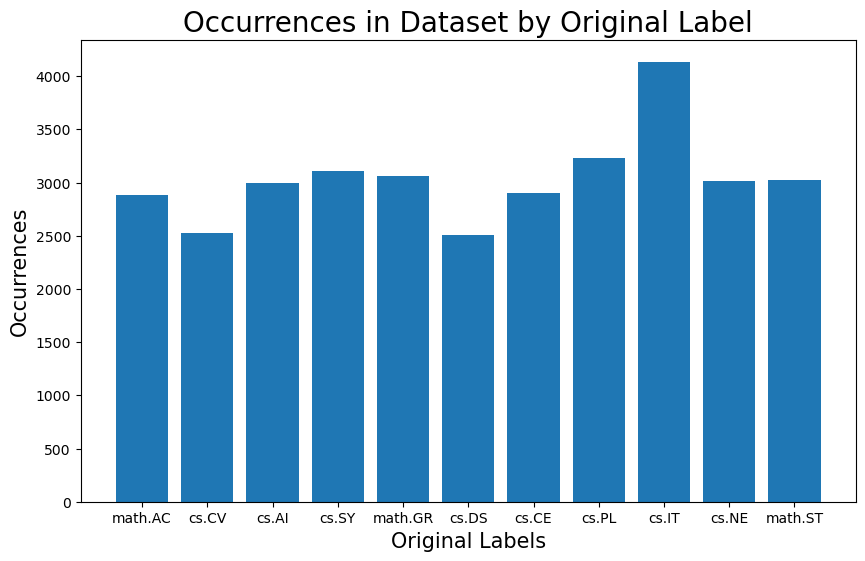

In [111]:
# Graph showing original class distribution
plt.figure(figsize=(10, 6))
plt.bar(ORIGINAL_LABELS, distribution)
plt.xlabel('Original Labels', fontsize=15)
plt.ylabel('Occurrences', fontsize=15)
plt.title('Occurrences in Dataset by Original Label', fontsize=20)
plt.show()

<h3>a. Converting 11 original classes to 2 classes, CS (1) or Math (0) </h3>

In [69]:
train_y = [classConversion[x] for x in train_data['label']]
test_y = [classConversion[x] for x in test_data['label']]
validation_y = [classConversion[x] for x in validation_data['label']]

<h3>b. Fit and transform vectorizer to train_data </h3>

In [70]:
vectorizer = HashingVectorizer(n_features=500)

train_X = vectorizer.fit_transform(train_data['text'])
test_X = vectorizer.transform(test_data['text'])
validation_X = vectorizer.transform(validation_data['text'])

<h2>5. Training Gaussian Naive Bayes model </h2

In [71]:
gnb = GaussianNB()
gnb.fit(train_X.toarray(), train_y)

GaussianNB()

<h2>6. Scoring accuraccies</h2>

<h3>a. Training accuracy score </h3>

In [72]:
training_accuracy = gnb.score(train_X.toarray(), train_y)
print(f"Accuracy train data points: {training_accuracy}")

Accuracy train data points: 0.8720586163167535


<h3>b. Validation accuracy score </h3>

In [73]:
validation_accuracy_score = gnb.score(validation_X.toarray(), validation_y)
print(f"Accuracy on validation: {validation_accuracy_score}")

Accuracy on validation: 0.8768


<h2>7. Varying feature numbers for hashing vectorizer </h2>

<h3>a. Cycling through features to score accuracies of different hashingvecotr feature sizes
</h3>
Note: Takes about 20 minutes to run and drains a lot of battery

In [74]:
# Number of features and accuracy result
features = [10, 50, 100, 200, 500, 1000, 2000]
training_accuracy = []
validation_accuracy = []

training_classification_reports = []
validation_classification_reports = []

for vectorSize in features:
    
    vectorizer = HashingVectorizer(n_features=vectorSize)
    
    # Fit to vectorizer
    train_X = vectorizer.fit_transform(train_data['text'])
    validation_X = vectorizer.transform(validation_data['text'])
    
    # Train Model
    gnb = GaussianNB()
    gnb.fit(train_X.toarray(), train_y)
    
    # Append accuracies
    training_accuracy.append(gnb.score(train_X.toarray(), train_y))
    validation_accuracy.append(gnb.score(validation_X.toarray(), validation_y))

    # Predict
    train_predictions = gnb.predict(train_X.toarray())
    validation_predictions = gnb.predict(validation_X.toarray())

    # Classification reports
    training_report = classification_report(train_y, train_predictions, output_dict=True)
    validation_report = classification_report(validation_y, validation_predictions, output_dict=True)

    # Store results
    training_classification_reports.append(training_report)
    validation_classification_reports.append(validation_report)
    
    print(f"Finished feature size: {vectorSize}")
    print(f"Validation Classification Report:")
    print(classification_report(validation_y, validation_predictions, output_dict=False))
    print()
    

Finished feature size: 10
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       681
           1       0.82      0.91      0.86      1819

    accuracy                           0.79      2500
   macro avg       0.74      0.69      0.71      2500
weighted avg       0.78      0.79      0.78      2500


Finished feature size: 50
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       681
           1       0.89      0.90      0.90      1819

    accuracy                           0.85      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.85      0.85      0.85      2500


Finished feature size: 100
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       681
           1       0.91      0.90      0.91      1819


<h3>c. generate graphs with matplotlib </h3>


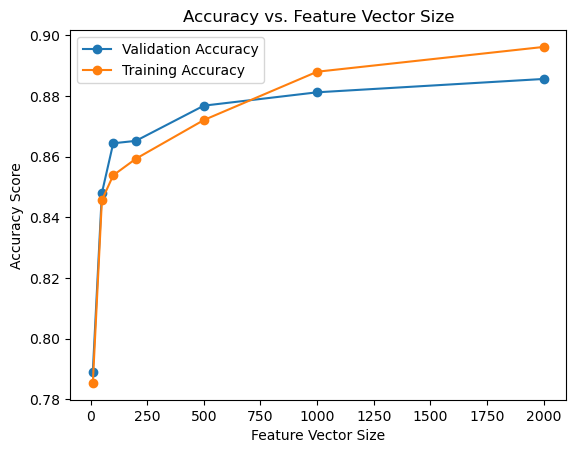

Features: [10, 50, 100, 200, 500, 1000, 2000]
Training Accuracies: [0.785437508806538, 0.8456390023953784, 0.8538466957869523, 0.8593067493307032, 0.8720586163167535, 0.887980836973369, 0.8961533042130477]
Validation Accuracies: [0.7892, 0.848, 0.8644, 0.8652, 0.8768, 0.8812, 0.8856]


In [75]:



plt.plot(features, validation_accuracy, marker='o', label='Validation Accuracy')
plt.plot(features, training_accuracy, marker='o', label='Training Accuracy')
plt.ylabel("Accuracy Score")
plt.xlabel("Feature Vector Size")
plt.legend()
plt.title('Accuracy vs. Feature Vector Size')

plt.show()

print(f'Features: {features}')
print(f'Training Accuracies: {training_accuracy}')
print(f'Validation Accuracies: {validation_accuracy}')

# Best results are for highest validation accuracy: 2000


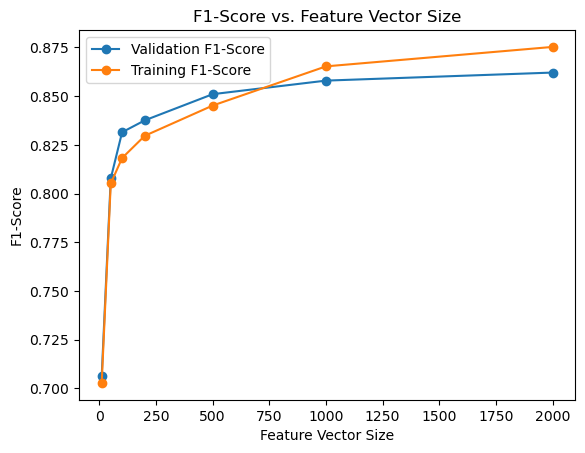

Features: [10, 50, 100, 200, 500, 1000, 2000]
Training F1-Scores: [0.7028338558649925, 0.8051860206857897, 0.8182377534257871, 0.8296423545280303, 0.8451820074976768, 0.8652849301749875, 0.875260475985251]
Validation F1-Scores: [0.7061617272471603, 0.8077415009600784, 0.8314765931427379, 0.8375759272293886, 0.8510177230864484, 0.8579729944017449, 0.8621015796408702]


In [76]:
# F1-Score vs. Feature vector size
train_f1_scores = []
val_f1_scores = []

for training_report in training_classification_reports:
    train_f1_scores.append(training_report['macro avg']['f1-score'])

for val_report in validation_classification_reports:
    val_f1_scores.append(val_report['macro avg']['f1-score'])

plt.plot(features, val_f1_scores, marker='o', label='Validation F1-Score')
plt.plot(features, train_f1_scores, marker='o', label='Training F1-Score')
plt.ylabel("F1-Score")
plt.xlabel("Feature Vector Size")
plt.legend()
plt.title('F1-Score vs. Feature Vector Size')

plt.show()

print(f'Features: {features}')
print(f'Training F1-Scores: {train_f1_scores}')
print(f'Validation F1-Scores: {val_f1_scores}')

# Best is still 2000 features, no signs of overfitting

<h3>d. Testing using feature size of 2000</h3>

In [77]:
best_feature_size = 2000

vectorizer = HashingVectorizer(n_features=best_feature_size)
    
# Fit to vectorizer
train_X = vectorizer.fit_transform(train_data['text'])
test_X = vectorizer.transform(test_data['text'])

# Train Model
gnb = GaussianNB()
gnb.fit(train_X.toarray(), train_y)

# Testing accuracies
test_accuracy = gnb.score(test_X.toarray(), test_y)

# Classification report
test_predictions = gnb.predict(test_X.toarray())

print(f"Final test accuracy: {test_accuracy}")

# Classification report
print('Classification Report: ')
print(classification_report(test_y, test_predictions, output_dict=False))

Final test accuracy: 0.8904
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       658
           1       0.96      0.89      0.92      1842

    accuracy                           0.89      2500
   macro avg       0.85      0.89      0.87      2500
weighted avg       0.90      0.89      0.89      2500



## Error Analysis

In [78]:
# Code to shorten a document so we just see the title, classification, authors, and a few lines
def shorten_document(text):
    # Find the index of the line containing "arXiv"
    arxiv_index = text.find("arXiv")
    if arxiv_index == -1:
        return text  # Return original text if "arXiv" is not found
    
    num_newlines = 0
    index = arxiv_index
    while num_newlines < 5:
        index = text.find("\n", index + 1)
        num_newlines += 1
        if index == -1:
            return text
    
    # Return the shortened text
    return text[:index] + "..."

In [83]:
# Get the indices of misclassified examples
misclassified_indices = (test_predictions != test_y).nonzero()[0]

# Print the misclassified examples
misclassified_examples = []
# print("Misclassified Examples:")
for idx in misclassified_indices:
    # print(f"True label: {test_y[idx]}, Predicted label: {test_predictions[idx]}")
    # print(f"Text: {shorten_document(test_data['text'][idx])}")
    # print()

    # Construct dict to save
    info = {}
    info['true label'] = test_y[idx]
    info['predicted label'] = test_predictions[idx]
    info['full text'] = test_data['text'][idx]
    info['shortened text'] = shorten_document(info['full text'])
    info['original true label index'] = test_data['label'][idx]
    info['original true label'] = ORIGINAL_LABELS[test_data['label'][idx]]

    misclassified_examples.append(info)


Code to randomly sample misclassified documents to analyze

In [84]:
# Pick k random samples to analyze
k = 1

random_misclassifications = random.sample(misclassified_examples, k)

for sample in random_misclassifications:
    print(sample['original true label'])
    print(sample['shortened text'])

cs.SY
arXiv:1801.08409v1 [math.NA] 14 Jan 2018

Computation of the State Bias and Initial States
for Stochastic State Space Systems in the General 2-D
Roesser Model Form...


### Plot misclassification errors vs original labels

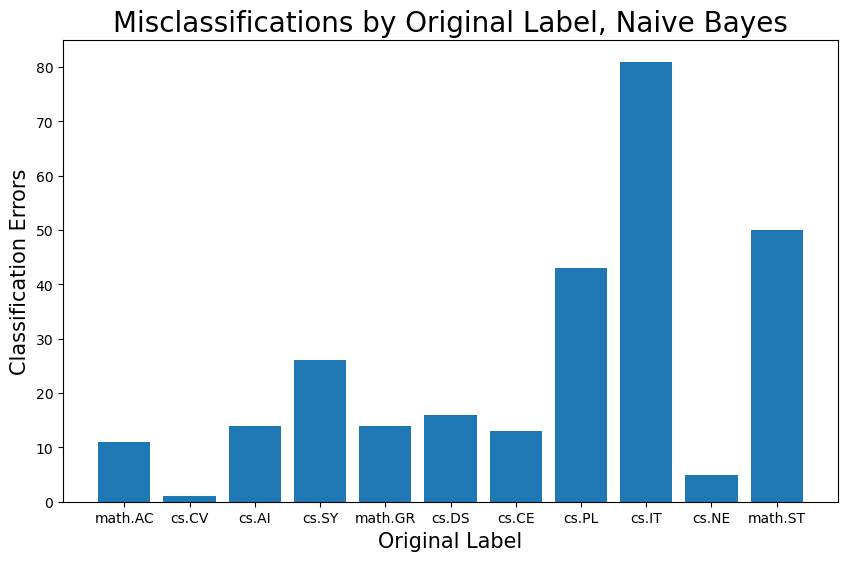

In [116]:
errors_by_label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for example in misclassified_examples:
    error_label_idx = example['original true label index']
    errors_by_label[error_label_idx] += 1

# Graph histogram 
plt.figure(figsize=(10, 6))
plt.bar(ORIGINAL_LABELS, errors_by_label)
plt.xlabel('Original Label', fontsize=15)
plt.ylabel('Classification Errors', fontsize=15)
plt.title('Misclassifications by Original Label, Naive Bayes', fontsize=20)
plt.show()

### For each class, pick a misclassified example and examine it

In [101]:
# Create map from each original label to all misclassified examples
misclassified_map = {}
for label in ORIGINAL_LABELS:
    misclassified_map[label] = list()

for example in misclassified_examples:
    misclassified_map[example['original true label']].append(example)

# for key in ORIGINAL_LABELS:
#     print(f'{key}: {len(misclassified_map[key])}')

# Function that returns a random misclassification given label
def rand_error_by_label(label):
    return random.sample(misclassified_map[label], 1)[0]

In [102]:
# Misclassification of each label

for label in ORIGINAL_LABELS:
    example = rand_error_by_label(label)

    print(f'Label: {label}')
    print(f"Example: {example['shortened text']}")
    print('---------------------------------\n')

Label: math.AC
Example: Dense Packings from Algebraic Number Fields and Codes1

arXiv:1506.00419v3 [math.NT] 11 Jan 2017

Shantian Cheng
Risk Management Institute,
National University of Singapore,...
---------------------------------

Label: cs.CV
Example: Exact Camera Location Recovery by Least Unsquared Deviations∗
Gilad Lerman1, Yunpeng Shi1, and Teng Zhang2
1

arXiv:1709.09683v2 [] 3 Oct 2017

2

School of Mathematics, University of Minnesota...
---------------------------------

Label: cs.AI
Example: arXiv:1802.02172v3 [] 24 Mar 2018

Augmented Artificial Intelligence:
a Conceptual Framework
1st Alexander N Gorban...
---------------------------------

Label: cs.SY
Example: On Recurrent Reachability for
Continuous Linear Dynamical Systems
Ventsislav Chonev

Joël Ouaknine

arXiv:1507.03632v2 [] 8 May 2016

Institute of Science and Technology Austria
vchonev@ist.ac.at
...
---------------------------------

Label: math.GR
Example: On the pronormality of subgroups of odd
indices in f



## Individual Error Analysis
#### Label: "math.AC"
- Paper: [Dense Packings from Algebraic Number Fields and Codes](https://arxiv.org/abs/1506.00419)

#### Label: "cs.CV"
- Paper: [Exact Camera Location Recovery by Least Unsquared Deviations](https://arxiv.org/abs/1709.09683)

#### Label: "cs.AI"
- Paper: [Augmented Artificial Intelligence: a Conceptual Framework](https://arxiv.org/abs/1802.02172)

#### Label: "cs.SY"
- Paper: [On Recurrent Reachability for Continuous Linear Dynamical Systems](https://arxiv.org/abs/1507.03632)

#### Label: "math.GR"
- Paper: [On the Pronormality of Subgroups of Odd Index in Finite Simple Groups](https://arxiv.org/abs/1807.00384)

#### Label: "cs.DS"
- Paper: [Data-driven HRF estimation for encoding and decoding models](https://arxiv.org/abs/1402.7015)

#### Label: "cs.CE"
- Paper: [Reasoning About LLVM Code Using Codewalker](https://arxiv.org/abs/1509.06083)

#### Label: "cs.PL"
- Paper: [Fusion of finite set distributions: Pointwise consistency and global cardinality](https://arxiv.org/abs/1802.06220)

#### Label: "cs.IT"
- Paper: [Simultaneous Feedback Vertex Set: A Parameterized Perspective](https://arxiv.org/abs/1510.01557)

#### Label: "cs.NE"
- Paper: [Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations](https://arxiv.org/abs/1706.04702)

#### Label: "math.ST"
- Paper: [Minimizing the CDF Path Length: A Novel Perspective on Uniformity and Uncertainty of Bounded Distributions](https://arxiv.org/abs/1508.01146)